**Using CNN for Sentiment Analysis of Noisy Audio data**
In this project we will see how CNNs perform on classification of noisy audio data.
This is a sample quick run of the project - https://github.com/laveenbhatia/Using-CNN-for-Sentiment-Analysis-of-Noisy-Audio-Data.git

Cloning the github repository

In [1]:
! git clone https://github.com/laveenbhatia/Using-CNN-for-Sentiment-Analysis-of-Noisy-Audio-Data.git

Cloning into 'Using-CNN-for-Sentiment-Analysis-of-Noisy-Audio-Data'...
remote: Enumerating objects: 4475, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4475 (delta 2), reused 6 (delta 2), pack-reused 4469
Receiving objects: 100% (4475/4475), 518.55 MiB | 29.40 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Checking out files: 100% (4402/4402), done.


Installing required libraries using requirements.txt in the root directory of the github repo

In [8]:
%cd /content/Using-CNN-for-Sentiment-Analysis-of-Noisy-Audio-Data
!pip install -r requirements.txt

/content/Using-CNN-for-Sentiment-Analysis-of-Noisy-Audio-Data
  Using cached librosa-0.9.1-py3-none-any.whl (213 kB)
  Using cached matplotlib-3.4.2-cp37-cp37m-manylinux1_x86_64.whl (10.3 MB)
  Using cached numpy-1.19.5-cp37-cp37m-manylinux2010_x86_64.whl (14.8 MB)
     |████████████████████████████████| 454.4 MB 9.9 kB/s 
     |████████████████████████████████| 132 kB 56.2 MB/s 
     |████████████████████████████████| 462 kB 38.8 MB/s 
     |████████████████████████████████| 1.2 MB 53.5 MB/s 
     |████████████████████████████████| 4.0 MB 46.0 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68723 sha256=c98d68896b23fc47456653f3da0308c32930b7e6a8bbb79ff67509f551b372eb
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Succ

If there is an error due to follium incompatibility, please ignore as we are not using that dependency in our project.

Preprocessing the data

In [3]:
import librosa
import os
import numpy as np
from librosa import display
from matplotlib import pyplot as plt
from IPython import display

First Let us listen to one of the audio files

In [5]:
file_path = "/content/Using-CNN-for-Sentiment-Analysis-of-Noisy-Audio-Data/data/Audio/Negative/03bSnISJMiM_2.wav"
y, sr = librosa.load(file_path)
display.Audio(data=y, rate=sr)

Now Let us add some noise to the audio data
Following function takes an audio signal and adds some noise to it.
Here noise factor is a parameter, which takes a value between 0 and 1 and decides the intensity of noise being added with value closer to 0 means less noise and value closer to 1 means more noise.

In [6]:
def add_noise(signal, noise_factor):
  noise = np.random.normal(0, signal.std(), signal.size)
  noisy_signal = signal + noise * noise_factor
  return noisy_signal

Adding the noise

In [7]:
y = add_noise(y, 0.2)
display.Audio(data=y, rate=sr)

Now we will convert this audio signal into a mel spectrogram

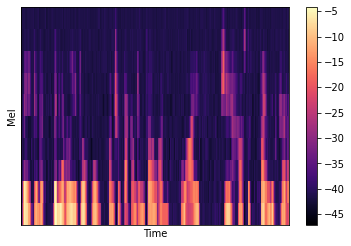

In [10]:
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=10)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
librosa.display.specshow(log_mel_spectrogram)
plt.xlabel("Time")
plt.ylabel("Mel")
plt.colorbar()
plt.show()

This way we can extract the spectrograms for all audio files and save them. The code to this is available in the github repo. In this quickrun, we can move on to the training of the model using the spectrogram which have been cloned from the github repo

In [11]:
import time
import os
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.filters import sobel

Preprocessing the spectrogram images

In [12]:
# This function will extract the sobel features of an image return the sobel image
def ext_sobel_features(image):
    sobel_image = sobel(image)
    return sobel_image

In [13]:
# This function will preprocess the training data
# -----------------------------------------------
# Arguments:
#   path - this is the path of the folder, relative to this file which contains training images
def preprocess_training_data(path):
    # The following piece of code is used to normalize the images and augment the training data
    # All the parameters can changed as per requirement
    train_batches = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.1,
        # This is the name of the preprocessing function defined above which extracts the sobel features
        preprocessing_function=ext_sobel_features
    )

    # Create training data from train_bathes
    training_data = train_batches.flow_from_directory(
        directory=path,
        target_size=(128, 128),
        subset='training'
    )

    # Create validation data from train_batches
    validation_data = train_batches.flow_from_directory(
        directory=path,
        target_size=(128, 128),
        subset='validation'
    )
    return training_data, validation_data

In [14]:
# This function is used to define the model
# Here we can play around with following hyper-parameters:
# 1. Add or delete layers
# 2. Change number of neurons for each layer
# 3. Change the activation function
def create_model(output_neurons):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(output_neurons, activation='softmax'))
    model.build((None, 128, 128, 3))
    return model

In [15]:
# This function will compile and fit the model
def train_model(model):
    # Compiling the model
    # Here we can change following hyper-parameters:
    #   1. optimizers
    #   2. loss function
    #   3. metrics
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Fitting the model
    # Here we can change following hyper-parameters:
    #   1. number of epochs
    #   2. batch size
    model.fit(train_data,
              epochs=2,
              batch_size=32,
              validation_data=valid_data,
              callbacks=[tensorboard])
    return model

In [17]:
# This variable stores the name of the folder with timestamp which will store the logs of the model
NAME = f'MNIST-CNN-{int(time.time())}'

# Used to store logs
tensorboard = TensorBoard(log_dir=f'logs\\{NAME}\\')

# Path of the folder, relative to this file where training spectrogram images are stored
TRAINING_IMAGES_DIRECTORY = '/content/Using-CNN-for-Sentiment-Analysis-of-Noisy-Audio-Data/data/Spectrogram/Training'
categories = os.listdir(TRAINING_IMAGES_DIRECTORY)
num_classes = len(categories)

# Creating the training and validation data for our model
train_data, valid_data = preprocess_training_data(TRAINING_IMAGES_DIRECTORY)

class_dict = train_data.class_indices
print(class_dict)

# Creating the model
model = create_model(output_neurons=num_classes)
print(model.summary())

# Training the model
model = train_model(model)

Found 1584 images belonging to 3 classes.
Found 175 images belonging to 3 classes.
{'Negative': 0, 'Neutral': 1, 'Positive': 2}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               73729

Now we evaluate our model

In [18]:
import tensorflow as tf
import numpy as np
from skimage.filters import sobel
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

Preprocessing the testing data

In [20]:
def ext_sobel_features(image):
    sobel_image = sobel(image)
    return sobel_image


test_batches = ImageDataGenerator(
        rescale=1. / 255,
        # This is the name of the preprocessing function defined above which extracts the sobel features
        preprocessing_function=ext_sobel_features
    )

TESTING_IMAGES_DIRECTORY = '/content/Using-CNN-for-Sentiment-Analysis-of-Noisy-Audio-Data/data/Spectrogram/Testing'

# Create training data from train_bathes
testing_data = test_batches.flow_from_directory(
    directory=TESTING_IMAGES_DIRECTORY,
    target_size=(128, 128),
)

X = []
y = []

count = 0

# Extract features and labels from from testing data iterator
for features, labels in testing_data:
    X.append(features)
    y.append(labels)
    count += 1
    if count == 13:
        break


X = np.array(X)
y = np.array(y)

X = np.reshape(X, (-1, 128, 128, 3))
y = np.reshape(y, (-1, 3))
y_one_hot = y
y = np.argmax(y, axis=1)

Found 440 images belonging to 3 classes.


In [22]:
# Make prediction on testing data
y_pred = model.predict(X, batch_size=32, verbose=1)
# Get the boolean labels from prediction
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y, y_pred_bool, output_dict=True))

13/13 [==============================] - 6s 450ms/step
{'0': {'precision': 0.9578313253012049, 'recall': 1.0, 'f1-score': 0.9784615384615385, 'support': 159}, '1': {'precision': 1.0, 'recall': 0.7848101265822784, 'f1-score': 0.8794326241134751, 'support': 79}, '2': {'precision': 0.9468085106382979, 'recall': 1.0, 'f1-score': 0.9726775956284154, 'support': 178}, 'accuracy': 0.9591346153846154, 'macro avg': {'precision': 0.9682132786465009, 'recall': 0.9282700421940927, 'f1-score': 0.943523919401143, 'support': 416}, 'weighted avg': {'precision': 0.9611228260012226, 'recall': 0.9591346153846154, 'f1-score': 0.957180706591844, 'support': 416}}


Get the auc score

In [23]:
auc_score = roc_auc_score(y_one_hot.ravel(), y_pred.ravel())
print("Auc Score - ", auc_score)

Auc Score -  0.9758633043639054


Draw roc curve

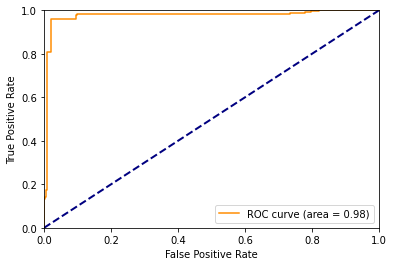

In [24]:
fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(), y_pred.ravel())

plt.plot(fpr, tpr, color="darkorange", label="ROC curve (area = %0.2f)" % auc_score)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()